In [3]:
import json
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import adjusted_rand_score
import seaborn as sns

In [4]:
with open('data/gse_processed_meta_human_conf.json') as f:
    gse_meta_human = json.load(f)

with open('data/gse_processed_meta_mouse_conf.json') as f:
    gse_meta_mouse = json.load(f)

In [5]:
rummaGEO_gses = list(set(list(gse_meta_human.keys()) + list(gse_meta_mouse.keys())))

In [6]:
human_bulk_d2h2 = pd.read_csv('data/benchmarking_clustering/D2H2-bulkrna-microarray-studies.csv', index_col=0)
mouse_bulk_d2h2 = pd.read_csv('data/benchmarking_clustering/D2H2-bulkrna-microarray-studies (1).csv', index_col=0)

In [19]:
human_d2h2_overlap = set(human_bulk_d2h2.index.values).intersection(set(rummaGEO_gses))
mouse_d2h2_overlap = set(mouse_bulk_d2h2.index.values).intersection(set(rummaGEO_gses))

In [20]:
d2h2_groupings = {}
for gse in human_d2h2_overlap:
    gse_meta = pd.read_csv(f'https://d2h2.s3.amazonaws.com/data/human/{gse}/{gse}_Metadata.tsv', index_col=0, sep='\t')
    gse_meta['condition + group'] = gse_meta['Condition'] + ' ' + gse_meta['Group']
    d2h2_groupings[gse] = {}
    for i, cond in enumerate(list(gse_meta['condition + group'].unique())):
        gsms_cond = list(gse_meta[gse_meta['condition + group'] == cond].index.values)
        d2h2_groupings[gse][i] = gsms_cond

In [21]:
for gse in mouse_d2h2_overlap:
    gse_meta = pd.read_csv(f'https://d2h2.s3.amazonaws.com/data/mouse/{gse}/{gse}_Metadata.tsv', index_col=0, sep='\t')
    gse_meta['condition + group'] = gse_meta['Condition'] + ' ' + gse_meta['Group']
    d2h2_groupings[gse] = {}
    for i, cond in enumerate(list(gse_meta['condition + group'].unique())):
        gsms_cond = list(gse_meta[gse_meta['condition + group'] == cond].index.values)
        d2h2_groupings[gse][i] = gsms_cond

In [22]:
rand_scores = []
for gse in d2h2_groupings:
    gse_cluster_df  = pd.DataFrame(columns=['d2h2 cluster'])
    for cluster in list(d2h2_groupings[gse]):
        for gsm in d2h2_groupings[gse][cluster]:
            gse_cluster_df.loc[gsm] = [cluster]
    if gse in human_d2h2_overlap:
        rummageo_meta = gse_meta_human[gse]
    else:
        rummageo_meta = gse_meta_mouse[gse]
    rummageo_col = []
    overlap = set(list(itertools.chain.from_iterable(list(rummageo_meta['samples'].values())))).intersection(set(gse_cluster_df.index.values))
    gse_cluster_df = gse_cluster_df.loc[list(overlap)]
    for gsm in gse_cluster_df.index.values:
        for cluster2 in rummageo_meta['samples']:
            if gsm in rummageo_meta['samples'][cluster2]:
                rummageo_col.append(cluster2)
    gse_cluster_df['rummageo cluster'] = rummageo_col
    
    rand_scores.append(adjusted_rand_score(gse_cluster_df['d2h2 cluster'], gse_cluster_df['rummageo cluster']))

In [23]:
print('# D2H2 Studies:', len(rand_scores),'Mean:', np.mean(rand_scores),'Std:', np.std(rand_scores))

# D2H2 Studies: 178 Mean: 0.8092985851389296 Std: 0.31174276476005036


In [24]:
with open('/Users/giacomomarino/rummageo-analysis/data/benchmarking_clustering/Disease_information_DEGs (1).gmt') as f:
    disease_info = f.readlines()

DiSignAtlas = {}
for l in disease_info:
    meta = l.split('\t')[1]
    gse = meta.split('|')[0]
    ctrl = meta.split('|')[1].split(';')
    pert = meta.split('|')[2].split(';')
    DiSignAtlas[gse] = {'0': ctrl, '1': pert}
    

In [25]:
disign_overlap = list(set(DiSignAtlas.keys()).intersection(set(rummaGEO_gses)))

In [26]:
rand_scores_disign = []
for gse in disign_overlap:
    gse_cluster_df  = pd.DataFrame(columns=['disign cond'])
    for cluster in list(DiSignAtlas[gse]):
        for gsm in DiSignAtlas[gse][cluster]:
            gse_cluster_df.loc[gsm] = [cluster]
    
    if gse in human_d2h2_overlap:
        rummageo_meta = gse_meta_human[gse]
    elif gse in mouse_d2h2_overlap:
        rummageo_meta = gse_meta_mouse[gse]

    rummageo_col = []
    overlap = set(list(itertools.chain.from_iterable(list(rummageo_meta['samples'].values())))).intersection(set(gse_cluster_df.index.values))
    gse_cluster_df = gse_cluster_df.loc[list(overlap)]
    for gsm in gse_cluster_df.index.values:
        for cluster2 in rummageo_meta['samples']:
            if gsm in rummageo_meta['samples'][cluster2]:
                rummageo_col.append(cluster2)
    gse_cluster_df['rummageo cluster'] = rummageo_col
    
    rand_scores_disign.append(adjusted_rand_score(gse_cluster_df['disign cond'], gse_cluster_df['rummageo cluster']))

In [27]:
print('# DiSignAtlas Studies:', len(rand_scores_disign),'Mean:', np.mean(rand_scores_disign), 'Std:', np.std(rand_scores_disign))

# DiSignAtlas Studies: 1010 Mean: 0.998019801980198 Std: 0.04445533528840327


In [28]:
auto_df_human = pd.read_csv('data/benchmarking_clustering/human_gsm4sig_v2.csv', index_col=0)
auto_df_mouse = pd.read_csv('data/benchmarking_clustering/mouse_gsm4sig_v2.csv', index_col=0)

In [29]:
auto_dict_human = auto_df_human.to_dict(orient='records')
auto_dict_mouse = auto_df_mouse.to_dict(orient='records')
autoSigGen_dict = {}
for val in auto_dict_human:
    autoSigGen_dict[val['series_id']] = {'0': val['ctrl_gsm'] , '1': val['pert_gsm']}
for val in auto_dict_mouse:
    autoSigGen_dict[val['series_id']] = {'0': val['ctrl_gsm'] , '1': val['pert_gsm']}

In [30]:
overlap_auto_sig_gen = set(autoSigGen_dict.keys()).intersection(set(rummaGEO_gses))

In [31]:
rand_scores_auto = []
for gse in overlap_auto_sig_gen:
    gse_cluster_df  = pd.DataFrame(columns=['autosiggen cond'])
    for cluster in list(autoSigGen_dict[gse]):
        for gsm in autoSigGen_dict[gse][cluster]:
            gse_cluster_df.loc[gsm] = [cluster]
    
    if gse in gse_meta_human:
        rummageo_meta = gse_meta_human[gse]
    elif gse in gse_meta_mouse:
        rummageo_meta = gse_meta_mouse[gse]

    rummageo_col = []
    overlap = set(list(itertools.chain.from_iterable(list(rummageo_meta['samples'].values())))).intersection(set(gse_cluster_df.index.values))
    gse_cluster_df = gse_cluster_df.loc[list(overlap)]
    for gsm in gse_cluster_df.index.values:
        for cluster2 in rummageo_meta['samples']:
            if gsm in rummageo_meta['samples'][cluster2]:
                rummageo_col.append(cluster2)
    gse_cluster_df['rummageo cluster'] = rummageo_col
    
    rand_scores_auto.append(adjusted_rand_score(gse_cluster_df['autosiggen cond'], gse_cluster_df['rummageo cluster']))

In [32]:
print('# AutoSigGen Studies:', len(rand_scores_auto),'Mean:', np.mean(rand_scores_auto), 'Std:', np.std(rand_scores_auto))

# AutoSigGen Studies: 10319 Mean: 1.0 Std: 0.0


In [33]:
scores_df = pd.DataFrame(data=[rand_scores, rand_scores_disign, rand_scores_auto], 
                         index=[f'D2H2 ({len(rand_scores)})', f'DiSignAtlas ({len(rand_scores_disign)})', f'AutoSigGen ({len(rand_scores_auto)})' ]).T

Text(0, 0.5, 'Adjusted Rand Index')

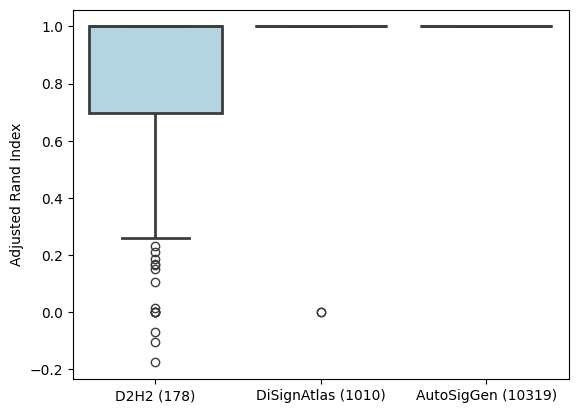

In [34]:
ax = sns.boxplot(data=scores_df, color='lightblue', linewidth=2)
ax.set_ylabel('Adjusted Rand Index')

In [2]:
import json
with open('data/sig_tissue_mapper.json') as f:
    sig_tissue_mapper = json.load(f)

In [4]:
study_tissues = {}
for sig in sig_tissue_mapper:
    gse = sig.split('-')[0]
    if gse not in study_tissues:
        study_tissues[gse] = sig_tissue_mapper[sig]

In [7]:
count = 0
for t in list(study_tissues.values()):
    if ',' in t:
        count +=1
print(count/len(study_tissues))

0.1458006718924972
